In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv('../data/rating.csv')
news_df = pd.read_csv('../data/data.csv')
traffic_df = pd.read_csv('../data/traffic_data/traffic.csv')
domains_location = pd.read_csv('../data/domains_location.csv')

In [6]:
data = pd.merge(news_df, domains_location, left_on='source_name', right_on='SourceCommonName', how='left')

In [8]:
#TF-IDF
token_pattern = r'\b[^\d\W]+\b'

tfidf_vectorizer_title = TfidfVectorizer(max_features=1000, stop_words='english', token_pattern=token_pattern)
tfidf_vectorizer_content = TfidfVectorizer(max_features=1000, stop_words='english', token_pattern=token_pattern)

tfidf_title = tfidf_vectorizer_title.fit_transform(data['title'].values.astype('U'))
tfidf_content = tfidf_vectorizer_content.fit_transform(data['content'].values.astype('U'))


In [9]:
#Key word extraction
title_feature_names = tfidf_vectorizer_title.get_feature_names_out()
content_feature_names = tfidf_vectorizer_content.get_feature_names_out()

def extract_keywords(tfidf_matrix, feature_names, top_n=5):
    keywords = []
    for doc in tfidf_matrix:
        top_indices = doc.indices[doc.data.argsort()[-top_n:]]
        top_keywords = [feature_names[i] for i in top_indices]
        keywords.append(top_keywords)
    return keywords

title_keywords = extract_keywords(tfidf_title, title_feature_names)
content_keywords = extract_keywords(tfidf_content, content_feature_names)

print("Keywords from titles for the first 5 articles:")
for i in range(min(5, len(title_keywords))):
    keywords = title_keywords[i]
    print(f"Article {i+1}: {', '.join(keywords)}")

print("\nKeywords from content for the first 5 articles:")
for i in range(min(5, len(content_keywords))):
    keywords = content_keywords[i]
    print(f"Article {i+1}: {', '.join(keywords)}")


Keywords from titles/headlines for the first 5 articles:
Article 1: climate, change, chief, stop, urges
Article 2: 
Article 3: climate, change, chief, stop, urges
Article 4: safety, push, warning
Article 5: s, hamas, cut

Keywords from content/body for the first 5 articles:
Article 1: general, climate, change, secretary, stop
Article 2: chars, d, x, https, winter
Article 3: general, climate, change, secretary, stop
Article 4: including, army, lost, went, lives
Article 5: foreign, major, launched, killed, taken


In [19]:
# Classification of Headlines into tags
tag_keywords = {
    "Breaking News": ["breaking", "urgent", "emergency", "alert"],
    "Politics": ["politics", "government", "election", "nation", "vote", "president"],
    "World News": ["world", "global", "international", "UN", "WHO", "foreign"],
    "Business/Finance": ["business", "finance", "economy", "market"],
    "Technology": ["technology", "tech", "innovation", "AI", "camera", "digital"],
    "Science": ["science", "scientific", "research", "discovery"],
    "Health": ["health", "medical", "wellness", "fitness"],
    "Entertainment": ["entertainment", "celebrity", "music", "radio" "film"],
    "Sports": ["sports", "athletics", "games", "competition"],
    "Environment": ["environment", "climate", "change", "green", "lakes", "earthquake" "ecology"],
    "Crime": ["crime", "criminal", "law", "justice"],
    "Education": ["education", "learning", "school", "college"],
    "Weather": ["weather", "forecast", "meteorology", "temperature"],
    "Other": []
}

def classify_headline(headline, keywords):
    max_matched_keywords = 0
    assigned_tag = "Other"
    for tag, tag_kw in tag_keywords.items():
        matched_keywords = sum(1 for kw in keywords if kw in tag_kw)
        if matched_keywords > max_matched_keywords:
            max_matched_keywords = matched_keywords
            assigned_tag = tag
    return assigned_tag

for i in range(min(20, len(title_keywords))):
    headline = data['title'][i]
    keywords = title_keywords[i]
    tag = classify_headline(headline, keywords)
    print(f"Headline: {headline} | Tag: {tag}")


Headline: UN Chief Urges World To 'Stop The Madness' Of Climate Change | Tag: Environment
Headline: RANDEBOOよりワンランク上の大人っぽさが漂うニットとベストが新登場。 | Tag: Other
Headline: UN Chief Urges World to 'Stop the Madness' of Climate Change | Tag: Environment
Headline: Sikkim warning: Hydroelectricity push must be accompanied by safety measures | Tag: Other
Headline: 200 foreigners, dual nationals cut down in Hamas assault. Here’s where they were from | Tag: Other
Headline: 中印交惡令尼泊爾機場難以發展國際航線 | Tag: Other
Headline: Pro-Israel rallies allowed in India but Palestine solidarity sees crackdown | Tag: Other
Headline: No nation in the world is buying more planes than India. Here’s why. | Tag: World News
Headline: More than 130 people have reportedly been taken to Gaza as hostages. Here's what we know | Tag: Other
Headline: World Cup: New Zealand v Bangladesh - clips, radio & text | Tag: World News
Headline: Glacial Lakes Threaten Millions in a Warming World | Tag: World News
Headline: UN Chief Urges Peace From

In [10]:
#Topic modelling
num_topics = 10
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_topics = lda_model.fit_transform(tfidf_content)

In [11]:
data['topic'] = lda_topics.argmax(axis=1)

In [12]:
#Analyze topics
data['published_at'] = pd.to_datetime(data['published_at'], format='mixed')
data['date'] = data['published_at'].dt.date
topic_counts = data.groupby(['date', 'topic']).size().reset_index(name='count')

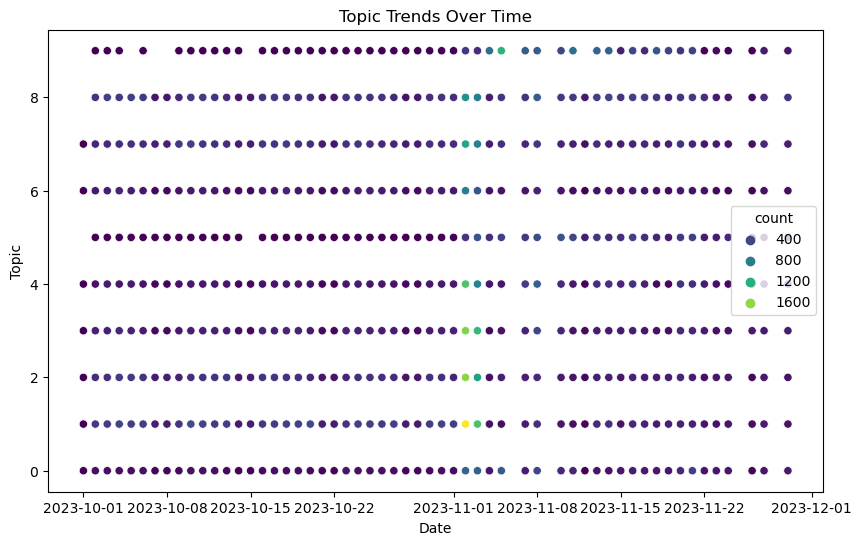

In [13]:
# Plotting topic trends
plt.figure(figsize=(10, 6))
sns.scatterplot(data=topic_counts, x='date', y='topic', hue='count', palette='viridis', legend=True)
plt.xlabel('Date')
plt.ylabel('Topic')
plt.title('Topic Trends Over Time')
plt.show()

In [19]:
# Websites reporting most diverse topics
diverse_topics = data.groupby('source_name')['topic'].nunique().sort_values(ascending=False).head(5)
print("Websites reporting the most diverse topics:")
print(diverse_topics)

Websites reporting the most diverse topics:
source_name
ABC News             10
The Punch            10
Wealthofgeeks.com    10
NPR                  10
Biztoc.com           10
Name: topic, dtype: int64
